In [ ]:
import warnings
from pprint import pprint
warnings.filterwarnings('ignore')

In [ ]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv('./credential/cred.env')

# Get the API key from the environment variables
api_key = os.environ.get("API_KEY")

# Check if the API key was found
if api_key:
  print("API Key loaded successfully.")
else:
  print("API Key not found in the environment variables.")
os.environ["OPENAI_API_KEY"] = api_key

API Key loaded successfully.


# Chapter 5. Cognitive Architectures with LangGraph

**จนถึงตอนนี้ เราได้พิจารณาคุณสมบัติที่พบมากที่สุดของแอปพลิเคชัน LLM แล้ว:**

- เทคนิคการเขียนพรอมต์ในคำนำและบทที่ 1

- RAG ในบทที่ 2 และ 3

- หน่วยความจำในบทที่ 4

คำถามถัดไปควรจะเป็น: เราจะประกอบชิ้นส่วนเหล่านี้เข้าด้วยกันในแอปพลิเคชันที่สอดคล้องกันซึ่งบรรลุเป้าหมายที่เราวางไว้ได้อย่างไร? เพื่อเปรียบเทียบกับโลกแห่งอิฐและปูน สระว่ายน้ำและบ้านชั้นเดียวสร้างขึ้นจากวัสดุชนิดเดียวกัน แต่เห็นได้ชัดว่ามีวัตถุประสงค์ที่แตกต่างกันมาก สิ่งที่ทำให้พวกมันเหมาะสมกับวัตถุประสงค์ที่แตกต่างกันโดยเฉพาะคือแผนสำหรับวิธีการรวมวัสดุเหล่านั้น กล่าวคือ สถาปัตยกรรมของพวกมัน เช่นเดียวกันกับการสร้างแอปพลิเคชัน LLM การตัดสินใจที่สำคัญที่สุดที่คุณต้องทำคือวิธีการประกอบส่วนประกอบต่างๆ ที่คุณมีอยู่ในมือ (เช่น RAG เทคนิคการเขียนพรอมต์ หน่วยความจำ) เข้าด้วยกันเพื่อให้บรรลุวัตถุประสงค์ของคุณ



**ก่อนที่เราจะดูสถาปัตยกรรมเฉพาะ มาเดินผ่านตัวอย่างกัน แอปพลิเคชัน LLM ใดๆ ที่คุณอาจสร้างขึ้นจะเริ่มต้นจากวัตถุประสงค์:**
-  สิ่งที่แอปพลิเคชันนั้นถูกออกแบบมาให้ทำ สมมติว่าคุณต้องการสร้างผู้ช่วยอีเมล - แอปพลิเคชัน LLM ที่อ่านอีเมลของคุณก่อนที่คุณจะทำและมีเป้าหมายเพื่อลดจำนวนอีเมลที่คุณต้องดู แอปพลิเคชันนี้อาจทำได้โดยการจัดเก็บอีเมลที่ไม่น่าสนใจบางรายการ ตอบกลับโดยตรงกับอีเมลบางรายการ และทำเครื่องหมายอีเมลอื่นๆ ว่าสมควรได้รับความสนใจของคุณในภายหลัง

คุณอาจต้องการให้แอปพลิเคชันผูกมัดด้วยข้อจำกัดบางอย่างในการดำเนินการ การระบุข้อจำกัดเหล่านั้นจะช่วยอย่างมาก เนื่องจากจะช่วยในการค้นหาสถาปัตยกรรมที่เหมาะสม บทที่ 8 ครอบคลุมข้อจำกัดเหล่านี้โดยละเอียดและวิธีการทำงานกับข้อจำกัดเหล่านั้น สำหรับผู้ช่วยอีเมลสมมุตินี้ สมมติว่าเราต้องการให้แอปพลิเคชันทำสิ่งต่อไปนี้:

- ลดจำนวนครั้งที่มันขัดจังหวะคุณให้น้อยที่สุด (ท้ายที่สุดแล้ว จุดประสงค์ทั้งหมดคือการประหยัดเวลา)

- หลีกเลี่ยงการให้ผู้ติดต่อทางอีเมลของคุณได้รับการตอบกลับที่คุณไม่เคยส่งเอง

สิ่งนี้บ่งบอกถึงการแลกเปลี่ยนที่สำคัญซึ่งมักเผชิญเมื่อสร้างแอปพลิเคชัน LLM: การแลกเปลี่ยนระหว่างตัวแทน (หรือความสามารถในการดำเนินการโดยอิสระ) และความน่าเชื่อถือ (หรือระดับที่คุณสามารถไว้วางใจผลลัพธ์ของมัน) โดยสัญชาตญาณ ผู้ช่วยอีเมลจะมีประโยชน์มากกว่าหากดำเนินการเพิ่มเติมโดยไม่ต้องมีส่วนร่วมจากคุณ แต่ถ้าคุณดำเนินการมากเกินไป มันจะหลีกเลี่ยงไม่ได้ที่จะส่งอีเมลที่คุณไม่ต้องการส่ง



**วิธีหนึ่งในการอธิบายระดับของความเป็นอิสระของแอปพลิเคชัน LLM คือการประเมินว่าพฤติกรรมของแอปพลิเคชันนั้นถูกกำหนดโดย LLM (เทียบกับโค้ด) มากน้อยเพียงใด:**

- ให้ LLM ตัดสินใจผลลัพธ์ของขั้นตอน (ตัวอย่างเช่น เขียนร่างการตอบกลับอีเมล)

- ให้ LLM ตัดสินใจขั้นตอนถัดไปที่จะดำเนินการ (ตัวอย่างเช่น สำหรับอีเมลใหม่ ตัดสินใจระหว่างการดำเนินการสามอย่างที่สามารถดำเนินการกับอีเมลได้: จัดเก็บ ตอบกลับ หรือทำเครื่องหมายเพื่อตรวจสอบ)

- ให้ LLM ตัดสินใจว่าขั้นตอนใดบ้างที่สามารถดำเนินการได้ (ตัวอย่างเช่น ให้ LLM เขียนโค้ดที่ดำเนินการตามขั้นตอนแบบไดนามิกที่คุณไม่ได้ตั้งโปรแกรมไว้ล่วงหน้าในแอปพลิเคชัน)



เราสามารถจำแนกสูตรอาหารยอดนิยมจำนวนมากสำหรับการสร้างแอปพลิเคชัน LLM ได้โดยพิจารณาจากตำแหน่งที่พวกมันอยู่ในสเปกตรัมของความเป็นอิสระ กล่าวคือ งานทั้งสามอย่างที่กล่าวถึงข้างต้นงานใดที่ดำเนินการโดย LLM และงานใดที่ยังคงอยู่ในมือของนักพัฒนาหรือผู้ใช้ สูตรอาหารเหล่านี้สามารถเรียกว่าสถาปัตยกรรมความรู้ ในสาขาปัญญาประดิษฐ์ คำศัพท์สถาปัตยกรรมความรู้ถูกใช้มานานแล้วเพื่อแสดงถึงแบบจำลองการให้เหตุผลของมนุษย์ (และการใช้งานในคอมพิวเตอร์) สถาปัตยกรรมความรู้ LLM (คำศัพท์นี้ถูกนำไปใช้กับ LLM เป็นครั้งแรกเท่าที่เรารู้ ในเอกสาร 1) สามารถกำหนดเป็นสูตรสำหรับขั้นตอนที่จะดำเนินการโดยแอปพลิเคชัน LLM (ดูรูป) ขั้นตอนหนึ่งคือ ตัวอย่างเช่น การดึงเอกสารที่เกี่ยวข้อง (RAG) หรือการเรียกใช้ LLM ด้วยพรอมต์แบบ chain-of-thought

---

<img align="top" src="./pics/Figure5-1.png"     style=" width:380px; padding: 10px; " >

---


**ตอนนี้มาดูสถาปัตยกรรมหลักหรือสูตรอาหารแต่ละอย่างที่คุณสามารถใช้เมื่อสร้างแอปพลิเคชันของคุณ (ดังแสดงในรูป):**

- **0: โค้ด**

นี่ไม่ใช่สถาปัตยกรรมความรู้ LLM (ดังนั้นเราจึงกำหนดหมายเลขเป็น 0) เนื่องจากไม่ได้ใช้ LLM เลย คุณสามารถคิดว่านี่คือซอฟต์แวร์ทั่วไปที่คุณคุ้นเคยกับการเขียน สถาปัตยกรรมที่น่าสนใจอันดับแรก (สำหรับหนังสือเล่มนี้) คืออันถัดไป

- **1: การเรียกใช้งาน LLM**

นี่คือตัวอย่างส่วนใหญ่ที่เราได้เห็นในหนังสือเล่มนี้ โดยมีการเรียกใช้งาน LLM เพียงครั้งเดียว ซึ่งมีประโยชน์ส่วนใหญ่เมื่อเป็นส่วนหนึ่งของแอปพลิเคชันขนาดใหญ่ที่ใช้ประโยชน์จาก LLM เพื่อให้บรรลุงานเฉพาะอย่าง เช่น การแปลหรือสรุปข้อความ

- **2: chain (เชน)**

ระดับถัดไป ดังนั้นจึงเกิดขึ้นจากการใช้การเรียกใช้งาน LLM หลายครั้งในลำดับที่กำหนดไว้ล่วงหน้า ตัวอย่างเช่น แอปพลิเคชัน text-to-SQL (ซึ่งรับคำอธิบายภาษาธรรมชาติของการคำนวณบางอย่างที่ต้องทำบนฐานข้อมูลเป็นอินพุตจากผู้ใช้) สามารถใช้การเรียกใช้งาน LLM สองครั้งในลำดับ:

การเรียกใช้งาน LLM ครั้งหนึ่งเพื่อสร้างคิวรี SQL จากคิวรีภาษาธรรมชาติที่ให้ไว้โดยผู้ใช้ และคำอธิบายเนื้อหาของฐานข้อมูลที่ให้ไว้โดยนักพัฒนา

และการเรียกใช้งาน LLM อีกครั้งหนึ่งเพื่อเขียนคำอธิบายของคิวรีที่เหมาะสมสำหรับผู้ใช้ที่ไม่ใช่ทางเทคนิค โดยให้คิวรีที่สร้างขึ้นในครั้งก่อนหน้านี้ ซึ่งสามารถใช้เพื่อให้ผู้ใช้ตรวจสอบว่าคิวรีที่สร้างขึ้นตรงกับคำขอของเขาหรือไม่

- **3: Router (เราเตอร์)**

ขั้นตอนถัดไปนี้มาจากการใช้ LLM เพื่อกำหนดลำดับขั้นตอนที่จะดำเนินการ กล่าวคือ ในขณะที่สถาปัตยกรรมเชนจะดำเนินการลำดับขั้นตอนคงที่เสมอ (ไม่ว่าจะมีกี่ขั้นตอน) ที่กำหนดโดยนักพัฒนา สถาปัตยกรรมเราเตอร์นั้นโดดเด่นด้วยการใช้ LLM เพื่อเลือกจากขั้นตอนที่กำหนดไว้ล่วงหน้าบางขั้นตอน ตัวอย่างจะเป็นแอปพลิเคชัน RAG ที่มีดัชนีเอกสารหลายตัวจากโดเมนต่างๆ ที่แตกต่างกัน โดยมีขั้นตอนดังต่อไปนี้:

  1. การเรียกใช้งาน LLM ครั้งหนึ่งเพื่อเลือกดัชนีที่มีอยู่ที่จะใช้ โดยพิจารณาจากคิวรีที่ผู้ใช้ป้อนและคำอธิบายดัชนีที่นักพัฒนาจัดเตรียมไว้

  2. ขั้นตอนการเรียกค้นที่ค้นหาดัชนีที่เลือกสำหรับเอกสารที่เกี่ยวข้องมากที่สุดสำหรับคิวรีของผู้ใช้

  3. การเรียกใช้งาน LLM อีกครั้งหนึ่งเพื่อสร้างคำตอบ โดยพิจารณาจากคิวรีที่ผู้ใช้ป้อนและรายการเอกสารที่เกี่ยวข้องที่ดึงมาจากดัชนี

**แค่นี้ก็เท่าที่เราจะไปในบทนี้ เราจะพูดถึงสถาปัตยกรรมเหล่านี้ทีละอย่าง บทต่อไปจะกล่าวถึงสถาปัตยกรรมตัวแทน ซึ่งใช้ประโยชน์จาก LLM มากยิ่งขึ้น แต่ก่อนอื่นมาพูดถึงเครื่องมือที่ดีกว่าบางอย่างเพื่อช่วยเราในการเดินทางครั้งนี้กัน**

# Architecture #1: LLM Call
ในฐานะตัวอย่างของสถาปัตยกรรมการเรียกใช้งาน LLM เราจะกลับไปที่แชทบอทที่เราสร้างขึ้นใน บทที่ 4 แชทบอทนี้จะตอบกลับข้อความของผู้ใช้โดยตรง

เริ่มต้นด้วยการสร้าง StateGraph ซึ่งเราจะเพิ่มโหนดเพื่อแทนการเรียกใช้งาน LLM:

In [ ]:
from typing import Annotated, TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI


model = ChatOpenAI()

class State(TypedDict):
	# Messages have the type "list". The `add_messages`
    # function in the annotation defines how this state should
    # be updated (in this case, it appends new messages to the
    # list, rather than replacing the previous messages)
	messages: Annotated[list, add_messages]

def chatbot(state: State):
  answer = model.invoke(state["messages"])
  return {"messages": [answer]}

builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_edge(START, 'chatbot')
builder.add_edge('chatbot', END)

graph = builder.compile()

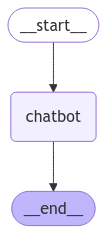

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

image_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)

display(Image(data=image_bytes))

คุณสามารถเรียกใช้ได้ด้วยเมธอด stream() ที่คุ้นเคยซึ่งคุณได้เห็นในบทก่อนหน้า



In [ ]:
from langchain_core.messages import HumanMessage
input = {"messages": [HumanMessage('hi!')]}
for chunk in graph.stream(input):
  print(chunk)

{'chatbot': {'messages': [AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-effcb53e-750b-411e-8bbf-b2644c9676ad-0', usage_metadata={'input_tokens': 9, 'output_tokens': 10, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}


สังเกตว่าอินพุตไปยังกราฟอยู่ในรูปร่างเดียวกับวัตถุ State ที่เราได้กำหนดไว้ก่อนหน้านี้ นั่นคือ เราส่งรายการข้อความในคีย์ messages ของพจนานุกรม
นี่คือสถาปัตยกรรมที่ง่ายที่สุดเท่าที่จะเป็นไปได้สำหรับการใช้ LLM ซึ่งไม่ได้หมายความว่าไม่ควรใช้เลย ต่อไปนี้คือตัวอย่างบางส่วนของสถานที่ที่คุณอาจเห็นการใช้งานในผลิตภัณฑ์ยอดนิยม ท่ามกลางผลิตภัณฑ์อื่นๆ อีกมากมาย:

- คุณสมบัติที่ขับเคลื่อนด้วย AI เช่น สรุปและแปล (เช่นที่คุณสามารถพบได้ใน Notion ซอฟต์แวร์เขียนยอดนิยม) สามารถขับเคลื่อนได้ด้วยการเรียกใช้งาน LLM เพียงครั้งเดียว
- การสร้างคิวรี SQL แบบง่ายสามารถขับเคลื่อนได้ด้วยการเรียกใช้งาน LLM เพียงครั้งเดียว ขึ้นอยู่กับ UX และผู้ใช้เป้าหมายที่นักพัฒนาตั้งใจไว้

# Architecture #2: Chain

สถาปัตยกรรมถัดไปนี้ขยายจากทั้งหมดโดยใช้การเรียกใช้งาน LLM หลายครั้งในลำดับที่กำหนดไว้ล่วงหน้า (นั่นคือ การเรียกใช้งานแอปพลิเคชันที่แตกต่างกันจะดำเนินการลำดับการเรียกใช้งาน LLM เดียวกัน แม้ว่าจะมีอินพุตและผลลัพธ์ที่แตกต่างกัน)

มาดูตัวอย่างแอปพลิเคชัน text-to-SQL ซึ่งรับคำอธิบายภาษาธรรมชาติของการคำนวณบางอย่างที่ต้องทำบนฐานข้อมูลเป็นอินพุตจากผู้ใช้ ก่อนหน้านี้เราได้กล่าวถึงว่าสิ่งนี้สามารถทำได้ด้วยการเรียกใช้งาน LLM เพียงครั้งเดียว เพื่อสร้างคิวรี SQL แต่เราสามารถสร้างแอปพลิเคชันที่ซับซ้อนยิ่งขึ้นโดยใช้การเรียกใช้งาน LLM หลายครั้งในลำดับ ผู้เขียนบางคนเรียกสถาปัตยกรรมนี้ว่า [flow engineering](https://arxiv.org/abs/2401.08500)

**ก่อนอื่นมาอธิบายโฟลว์เป็นคำพูด:**

1. การเรียกใช้งาน LLM ครั้งหนึ่งเพื่อสร้างคิวรี SQL จากคิวรีภาษาธรรมชาติที่ให้ไว้โดยผู้ใช้ และคำอธิบายเนื้อหาของฐานข้อมูลที่ให้ไว้โดยนักพัฒนา

2. การเรียกใช้งาน LLM อีกครั้งหนึ่งเพื่อเขียนคำอธิบายของคิวรีที่เหมาะสมสำหรับผู้ใช้ที่ไม่ใช่ทางเทคนิค โดยให้คิวรีที่สร้างขึ้นในครั้งก่อนหน้านี้ ซึ่งสามารถใช้เพื่อให้ผู้ใช้ตรวจสอบว่าคิวรีที่สร้างขึ้นตรงกับคำขอของเขาหรือไม่

คุณยังสามารถขยายสิ่งนี้ต่อไปอีก (แต่เราจะไม่ทำเช่นนั้นที่นี่) ด้วยขั้นตอนเพิ่มเติมที่จะดำเนินการหลังจากสองขั้นตอนก่อนหน้า:

1. ดำเนินการคิวรีกับฐานข้อมูล ซึ่งจะส่งคืนตารางสองมิติ

2. ใช้การเรียกใช้งาน LLM ครั้งที่สามเพื่อสรุปผลลัพธ์ของคิวรีเป็นคำตอบข้อความสำหรับคำถามเดิมของผู้ใช้

และตอนนี้มาใช้ LangGraph เพื่อนำไปใช้กัน:

In [ ]:
from typing import Annotated, TypedDict

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI

from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages

# useful to generate SQL query
model_low_temp = ChatOpenAI(temperature=0.1)
# useful to generate natural language outputs
model_high_temp = ChatOpenAI(temperature=0.7)

class State(TypedDict):
    # to track conversation history
    messages: Annotated[list, add_messages]
    # input
    user_query: str
    # output
    sql_query: str
    sql_explanation: str

class Input(TypedDict):
    user_query: str

class Output(TypedDict):
    sql_query: str
    sql_explanation: str

generate_prompt = SystemMessage(
    "You are a helpful data analyst who generates SQL queries for users based on their questions."
)

def generate_sql(state: State) -> State:
    user_message = HumanMessage(state["user_query"])
    messages = [generate_prompt, *state["messages"], user_message]
    res = model_low_temp.invoke(messages)
    return {
        "sql_query": res.content,
        # update conversation history
        "messages": [user_message, res],
    }

explain_prompt = SystemMessage(
    "You are a helpful data analyst who explains SQL queries to users."
)

def explain_sql(state: State) -> State:
    messages = [
        explain_prompt,
        # contains user's query and SQL query from prev step
        *state["messages"],
    ]
    res = model_high_temp.invoke(messages)
    return {
        "sql_explanation": res.content,
        # update conversation history
        "messages": res,
    }

builder = StateGraph(State, input=Input, output=Output)
builder.add_node("generate_sql", generate_sql)
builder.add_node("explain_sql", explain_sql)
builder.add_edge(START, "generate_sql")
builder.add_edge("generate_sql", "explain_sql")
builder.add_edge("explain_sql", END)

graph = builder.compile()

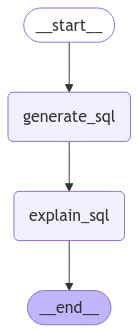

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

image_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)

display(Image(data=image_bytes))

In [ ]:
result = graph.invoke({
  "user_query": "What is the total sales for each product?"
})

pprint(result)

{'sql_explanation': 'Is there anything else you would like to know about SQL '
                    'queries?',
 'sql_query': 'To calculate the total sales for each product, you can use the '
              'following SQL query:\n'
              '\n'
              '```sql\n'
              'SELECT product_name, SUM(sales_amount) AS total_sales\n'
              'FROM sales_data\n'
              'GROUP BY product_name;\n'
              '```\n'
              '\n'
              'This query will group the sales data by product name and '
              'calculate the total sales amount for each product.'}


ก่อนอื่น โหนด `generate_sql` จะถูกเรียกใช้งาน ซึ่งจะเติมคีย์ `sql_query` ในสถานะ (ซึ่งจะเป็นส่วนหนึ่งของผลลัพธ์สุดท้าย) และอัปเดตคีย์ messages ด้วยข้อความใหม่ จากนั้นโหนด `explain_sql` จะทำงาน โดยรับคิวรี SQL ที่สร้างขึ้นในขั้นตอนก่อนหน้าและเติมคีย์ `sql_explanation` ในสถานะ ณ จุดนี้ กราฟจะเสร็จสิ้นการทำงาน และผลลัพธ์จะถูกส่งกลับไปยังผู้เรียก

โปรดทราบถึงการใช้รูปแบบอินพุตและเอาต์พุตที่แยกต่างหากเมื่อสร้าง `StateGraph` สิ่งนี้ช่วยให้คุณปรับแต่งส่วนใดของสถานะที่ยอมรับเป็นอินพุตจากผู้ใช้และส่วนใดที่ส่งคืนเป็นผลลัพธ์สุดท้าย คีย์สถานะที่เหลือจะถูกใช้โดยโหนดกราฟภายในเพื่อรักษาสถานะระดับกลาง และจะถูกทำให้ผู้ใช้สามารถเข้าถึงได้ในฐานะส่วนหนึ่งของเอาต์พุตแบบสตรีมที่สร้างโดย stream()

# Architecture #3: Router

**สถาปัตยกรรมถัดไปนี้ก้าวขึ้นไปบนบันไดแห่งความเป็นอิสระโดยมอบหมายให้ LLM รับผิดชอบต่อไปนี้ซึ่งเราระบุไว้ก่อนหน้านี้:** การตัดสินใจขั้นตอนถัดไปที่จะดำเนินการ กล่าวคือ ในขณะที่สถาปัตยกรรมเชนจะดำเนินการลำดับขั้นตอนคงที่เสมอ (ไม่ว่าจะมีกี่ขั้นตอน) สถาปัตยกรรมเราเตอร์นั้นโดดเด่นด้วยการใช้ LLM เพื่อเลือกจากขั้นตอนที่กำหนดไว้ล่วงหน้าบางขั้นตอน

มาใช้ตัวอย่างของแอปพลิเคชัน RAG ที่มีการเข้าถึงดัชนีเอกสารหลายตัวจากโดเมนต่างๆ **(ดูข้อมูลเพิ่มเติมเกี่ยวกับการสร้างดัชนีใน บทที่ 2) โดยปกติ คุณสามารถดึงประสิทธิภาพที่ดีกว่าจาก LLM ได้โดยหลีกเลี่ยงการรวมข้อมูลที่ไม่เกี่ยวข้องในพรอมต์** ดังนั้น ในการสร้างแอปพลิเคชันนี้ เราควรพยายามเลือกดัชนีที่ถูกต้องที่จะใช้สำหรับแต่ละคิวรีและใช้เพียงดัชนีนั้นเท่านั้น การพัฒนาที่สำคัญในสถาปัตยกรรมนี้คือการใช้ LLM เพื่อตัดสินใจนี้ โดยใช้ LLM เพื่อประเมินแต่ละคิวรีที่ป้อนเข้ามาและตัดสินใจว่าควรใช้ดัชนีใดสำหรับคิวรีนั้นโดยเฉพาะ

**หมายเหตุ**

ก่อนการถือกำเนิดของ LLM วิธีปกติในการแก้ปัญหานี้คือการสร้างโมเดลการจำแนกประเภทโดยใช้เทคนิค ML และชุดข้อมูลการแมปคิวรีผู้ใช้ตัวอย่างกับดัชนีที่ถูกต้อง ซึ่งอาจพิสูจน์ได้ว่าท้าทายพอสมควร เนื่องจากต้อง:

- รวบรวมชุดข้อมูลนั้นด้วยตนเอง

- สร้างคุณลักษณะ (แอตทริบิวต์เชิงปริมาณ) เพียงพอจากแต่ละคิวรีของผู้ใช้เพื่อเปิดใช้งานการฝึกอบรมตัวจำแนกประเภทสำหรับงานนี้

LLM เมื่อพิจารณาจากการเข้ารหัสภาษาธรรมชาติของมนุษย์ สามารถทำหน้าที่เป็นตัวจำแนกประเภทนี้ได้อย่างมีประสิทธิภาพโดยไม่มีตัวอย่างหรือการฝึกอบรมเพิ่มเติมเลย



**ก่อนอื่น มาอธิบายโฟลว์เป็นคำพูด:**

1. การเรียกใช้งาน LLM ครั้งหนึ่งเพื่อเลือกดัชนีที่มีอยู่ที่จะใช้ โดยพิจารณาจากคิวรีที่ผู้ใช้ป้อนและคำอธิบายดัชนีที่นักพัฒนาจัดเตรียมไว้

2. ขั้นตอนการเรียกค้นที่ค้นหาดัชนีที่เลือกสำหรับเอกสารที่เกี่ยวข้องมากที่สุดสำหรับคิวรีของผู้ใช้

3. การเรียกใช้งาน LLM อีกครั้งหนึ่งเพื่อสร้างคำตอบ โดยพิจารณาจากคิวรีที่ผู้ใช้ป้อนและรายการเอกสารที่เกี่ยวข้องที่ดึงมาจากดัชนี

และตอนนี้มาใช้ LangGraph เพื่อนำไปใช้กัน:

In [ ]:
from typing import Annotated, Literal, TypedDict

from langchain_core.documents import Document
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.vectorstores.in_memory import InMemoryVectorStore
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages

embeddings = OpenAIEmbeddings()
# useful to generate SQL query
model_low_temp = ChatOpenAI(temperature=0.1)
# useful to generate natural language outputs
model_high_temp = ChatOpenAI(temperature=0.7)

class State(TypedDict):
    # to track conversation history
    messages: Annotated[list, add_messages]
    # input
    user_query: str
    # output
    domain: Literal["records", "insurance"]
    documents: list[Document]
    answer: str

class Input(TypedDict):
    user_query: str

class Output(TypedDict):
    documents: list[Document]
    answer: str

# refer to Chapter 2 on how to fill a vector store with documents
medical_records_store = InMemoryVectorStore.from_documents([], embeddings)
medical_records_retriever = medical_records_store.as_retriever()

insurance_faqs_store = InMemoryVectorStore.from_documents([], embeddings)
insurance_faqs_retriever = insurance_faqs_store.as_retriever()

router_prompt = SystemMessage("""
You need to decide which domain to route the user query to. You have two
domains to choose from:
- records: contains medical records of the patient, such as diagnosis, treatment,
    and prescriptions.
- insurance: contains frequently asked questions about insurance policies,
    claims, and coverage.

Output only the domain name.
"""
)

def router_node(state: State) -> State:
    user_message = HumanMessage(state["user_query"])
    messages = [router_prompt, *state["messages"], user_message]
    res = model_low_temp.invoke(messages)
    return {
        "domain": res.content,
        # update conversation history
        "messages": [user_message, res],
    }

def pick_retriever(
    state: State,
) -> Literal["retrieve_medical_records", "retrieve_insurance_faqs"]:
    if state["domain"] == "records":
        return "retrieve_medical_records"
    else:
        return "retrieve_insurance_faqs"

def retrieve_medical_records(state: State) -> State:
    documents = medical_records_retriever.invoke(state["user_query"])
    return {
        "documents": documents,
    }

def retrieve_insurance_faqs(state: State) -> State:
    documents = insurance_faqs_retriever.invoke(state["user_query"])
    return {
        "documents": documents,
    }

medical_records_prompt = SystemMessage(
    """You are a helpful medical chatbot who answers questions based on the
        patient's medical records, such as diagnosis, treatment, and
        prescriptions."""
)

insurance_faqs_prompt = SystemMessage(
    """You are a helpful medical insurance chatbot who answers frequently asked
        questions about insurance policies, claims, and coverage."""
)

def generate_answer(state: State) -> State:
    if state["domain"] == "records":
        prompt = medical_records_prompt
    else:
        prompt = insurance_faqs_prompt
    messages = [
        prompt,
        *state["messages"],
        HumanMessage(f"Documents: {state['documents']}"),
    ]
    res = model_high_temp.invoke(messages)
    return {
        "answer": res.content,
        # update conversation history
        "messages": res,
    }

builder = StateGraph(State, input=Input, output=Output)
builder.add_node("router", router_node)
builder.add_node("retrieve_medical_records", retrieve_medical_records)
builder.add_node("retrieve_insurance_faqs", retrieve_insurance_faqs)
builder.add_node("generate_answer", generate_answer)
builder.add_edge(START, "router")
builder.add_conditional_edges("router", pick_retriever)
builder.add_edge("retrieve_medical_records", "generate_answer")
builder.add_edge("retrieve_insurance_faqs", "generate_answer")
builder.add_edge("generate_answer", END)

graph = builder.compile()

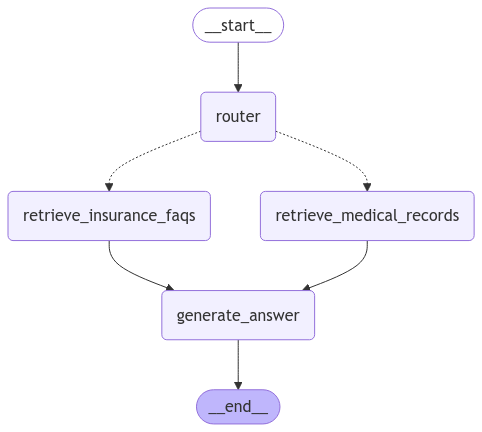

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

image_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)

display(Image(data=image_bytes))

สังเกตว่าตอนนี้เริ่มมีประโยชน์มากขึ้น เนื่องจากแสดงเส้นทางที่เป็นไปได้สองเส้นทางผ่านกราฟ ผ่าน retrieve_medical_records หรือผ่าน retrieve_insurance_faqs และสำหรับทั้งสองเส้นทางนั้น เราจะเยี่ยมชมโหนด router ก่อน และสิ้นสุดที่การเยี่ยมชมโหนด generate_answer เส้นทางที่เป็นไปได้สองเส้นทางนี้ถูกนำไปใช้ผ่านการใช้ขอบที่มีเงื่อนไข ซึ่งนำไปใช้ในฟังก์ชัน pick_retriever ซึ่งแมปโดเมนที่เลือกโดย LLM ไปยังหนึ่งในสองโหนดที่กล่าวถึงข้างต้น ขอบที่มีเงื่อนไขแสดงในรูปข้างบน เป็นเส้นประจากโหนดต้นทางไปยังโหนดปลายทาง

และตอนนี้สำหรับตัวอย่างอินพุตและเอาต์พุต ครั้งนี้มีเอาต์พุตแบบสตรีม:



In [ ]:
input = {
  "user_query": "Am I covered for COVID-19 treatment?"
}
for c in graph.stream(input):
    pprint(c)

{'router': {'domain': 'insurance',
            'messages': [HumanMessage(content='Am I covered for COVID-19 treatment?', additional_kwargs={}, response_metadata={}, id='8ba66802-a81d-4c7b-be76-70a05ef3df37'),
                         AIMessage(content='insurance', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 88, 'total_tokens': 90, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-90504bc1-2bd5-42a9-8feb-fb2fa68f2c2f-0', usage_metadata={'input_tokens': 88, 'output_tokens': 2, 'total_tokens': 90, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}
{'retrieve_insurance_faqs': {'documents': []}}


สตรีมเอาต์พุตนี้ประกอบด้วยค่าที่ส่งคืนโดยแต่ละโหนดที่เรียกใช้ระหว่างการดำเนินการกราฟนี้ คีย์ระดับบนสุดในแต่ละพจนานุกรมคือชื่อของโหนด และค่าสำหรับคีย์นั้นคือสิ่งที่โหนดนั้นส่งคืน:

1. โหนด router ส่งคืนการอัปเดตไปยัง messages (สิ่งนี้จะช่วยให้เราสามารถดำเนินการสนทนานี้ต่อไปได้อย่างง่ายดายโดยใช้เทคนิคหน่วยความจำที่อธิบายไว้ก่อนหน้านี้) และโดเมนที่ LLM เลือกสำหรับคิวรีของผู้ใช้ในกรณีนี้คือ insurance

2. จากนั้นฟังก์ชัน pick_retriever ได้เรียกใช้และส่งคืนชื่อของโหนดถัดไปที่จะเรียกใช้ โดยยึดตามโดเมนที่ระบุโดยการเรียกใช้งาน LLM ในขั้นตอนก่อนหน้า

3. จากนั้นโหนด retrieve_insurance_faqs ได้เรียกใช้และส่งคืนชุดเอกสารที่เกี่ยวข้องจากดัชนีนั้น ซึ่งหมายความว่าบนภาพวาดของกราฟที่เห็นก่อนหน้านี้ เราได้เลือกเส้นทางด้านซ้าย ตามที่ LLM ตัดสินใจ

4. สุดท้าย โหนด generate_answer ได้เรียกใช้ ซึ่งนำเอกสารเหล่านั้นและคิวรีเดิมของผู้ใช้มาสร้างคำตอบสำหรับคำถาม ซึ่งถูกเขียนลงในสถานะ (พร้อมกับการอัปเดตขั้นสุดท้ายไปยังคีย์ messages)

# Summary
**สรุป**

บทนี้กล่าวถึงการแลกเปลี่ยนที่สำคัญเมื่อสร้างแอปพลิเคชัน LLM: ตัวแทนกับการควบคุม ยิ่งแอปพลิเคชัน LLM มีความเป็นอิสระมากเท่าใด ก็ยิ่งสามารถทำได้มากขึ้นเท่านั้น—แต่สิ่งนี้จะเพิ่มความต้องการกลไกการควบคุมการกระทำมากขึ้น เราได้ย้ายไปยังสถาปัตยกรรมความรู้ที่แตกต่างกันซึ่งสร้างสมดุลที่แตกต่างกันระหว่างตัวแทนและการควบคุม

**บทที่ 6 พูดถึงสถาปัตยกรรมความรู้ที่ทรงพลังที่สุดที่เราเคยเห็นมา: สถาปัตยกรรมตัวแทน**